In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import optuna
import tensorflow as tf
from tensorflow import keras

In [21]:
train = pd.read_csv('data/train_1.csv')

In [22]:
for col in train.drop("Page", axis=1).columns:
    train[col] = train[col].fillna(0)
    train[col] = train[col].astype(np.int32)

In [23]:
train = train.melt(id_vars=["Page"], var_name='date', value_name='Visits')

In [24]:
train.head()

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0


In [25]:
train = train.groupby('date')['Visits'].sum().reset_index()

In [26]:
train.head()

,date,Visits
0,2015-07-01,148672476
1,2015-07-02,149593840
2,2015-07-03,141164198
3,2015-07-04,145612937
4,2015-07-05,151495372


<Axes: >

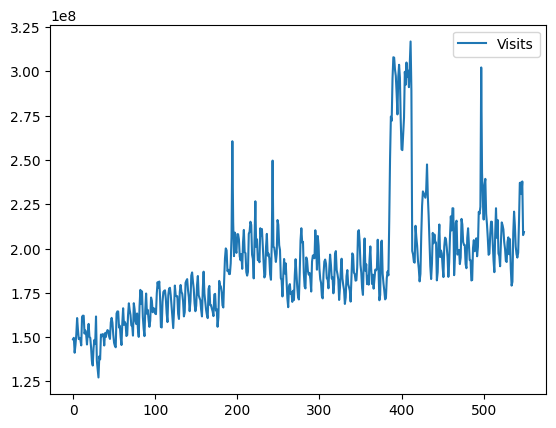

In [27]:
train.plot()

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    550 non-null    object
 1   Visits  550 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 6.6+ KB


In [29]:
train['date'] = pd.to_datetime(train['date'])
train = train.set_index('date')

In [33]:
train.head()

,Visits
date,
2015-07-01,148672476
2015-07-02,149593840
2015-07-03,141164198
2015-07-04,145612937
2015-07-05,151495372


In [51]:
y = train.copy()
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

X_2 = train.drop('Visits', axis=1)
X_2["dump"] = 1
X_2["day"] = y.index.day
X_2["month"] = y.index.month
X_2 = X_2.drop('dump', axis=1)

In [52]:
X_1.head()

,trend
date,
2015-07-01,1.0
2015-07-02,2.0
2015-07-03,3.0
2015-07-04,4.0
2015-07-05,5.0


In [50]:
y.head()

,Visits
date,
2015-07-01,148672476
2015-07-02,149593840
2015-07-03,141164198
2015-07-04,145612937
2015-07-05,151495372


In [53]:
X_2.head()

,day,month
date,,
2015-07-01,1,7
2015-07-02,2,7
2015-07-03,3,7
2015-07-04,4,7
2015-07-05,5,7


In [59]:
linear_regression = LinearRegression()

linear_regression.fit(X_1, y)

y_fit = pd.DataFrame(
    linear_regression.predict(X_1),
    index=X_1.index, columns=["Visits"],
)

y_resid = y - y_fit
# y_resid = y_resid.stack().squeeze() # wide to long

In [58]:
y_resid.stack().squeeze().head()

date              
2015-07-01  Visits   -6.491828e+06
2015-07-02  Visits   -5.697364e+06
2015-07-03  Visits   -1.425391e+07
2015-07-04  Visits   -9.932069e+06
2015-07-05  Visits   -4.176535e+06
dtype: float64

<Axes: xlabel='date'>

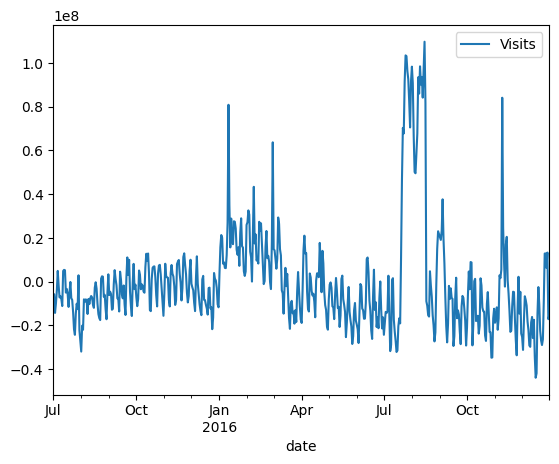

In [60]:
y_resid.plot()

In [61]:
target_name = "Visits"

In [64]:
def calculate_smape(actual, predicted) -> float: 

    # Convert actual and predicted to numpy 
    # array data type if not already 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), 
        np.array(predicted) 

    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2) 
        )*100, 2
    ) 

In [68]:
run_optimization = True

def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        
    }
    
    params['booster'] = 'gbtree'
    params['objective'] = 'reg:squarederror'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "hist"

    xgb_model = XGBRegressor(**params)

    xgb_model.fit(X_2, y_resid)

    y_pred = xgb_model.predict(X_2)
    smape = calculate_smape(y_resid["Visits"].to_numpy(), y_pred)
    
    return smape

if run_optimization:
    
    xgb_study = optuna.create_study(direction="minimize")

    xgb_study.optimize(objective, n_trials=100)
    best_xgb_params = xgb_study.best_params
    best_xgb_value = xgb_study.best_value

else:
    
    best_xgb_value = 119.30000
    best_xgb_params = {
        'learning_rate': 0.3128012856997987, 
        'gamma': 0.21433490648377135, 
        'max_depth': 3, 
        'min_child_weight': 4, 
        'subsample': 0.5856478365522627, 
        'colsample_bytree': 0.6914742723899157, 
        'grow_policy': 'lossguide', 
        'n_estimators': 290, 
        'reg_lambda': 0.25361307191166793, 
        'reg_alpha': 8.883674143094204
    }

print(f"best optmized accuracy: {best_xgb_value:0.5f}")
print(f"best hyperparameters: {best_xgb_params}")

best_xgb_params['booster'] = 'gbtree'
best_xgb_params['objective'] = 'reg:squarederror'
best_xgb_params['tree_method'] = "hist"
best_xgb_params["device"] = "cuda"
best_xgb_params["verbosity"] = 0

[I 2024-05-14 12:35:32,094] A new study created in memory with name: no-name-e1cec439-d5c0-47e2-8019-4e37e6c9fff0
[I 2024-05-14 12:35:34,083] Trial 0 finished with value: 123.08 and parameters: {'learning_rate': 0.05912186555004692, 'gamma': 0.13306426887823564, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.698637898899445, 'colsample_bytree': 0.4288596324168098, 'grow_policy': 'lossguide', 'n_estimators': 719, 'reg_lambda': 3.8400900759806133e-07, 'reg_alpha': 1.1443987028369802}. Best is trial 0 with value: 123.08.
[I 2024-05-14 12:35:34,808] Trial 1 finished with value: 123.85 and parameters: {'learning_rate': 0.020166692885406436, 'gamma': 0.23990776258691354, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.9962915292913621, 'colsample_bytree': 0.6174052966490604, 'grow_policy': 'depthwise', 'n_estimators': 612, 'reg_lambda': 9.236063293638023e-05, 'reg_alpha': 72.41471054202579}. Best is trial 0 with value: 123.08.
[I 2024-05-14 12:35:36,553] Trial 2 finished with va

best optmized accuracy: 119.30000
best hyperparameters: {'learning_rate': 0.3128012856997987, 'gamma': 0.21433490648377135, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5856478365522627, 'colsample_bytree': 0.6914742723899157, 'grow_policy': 'lossguide', 'n_estimators': 290, 'reg_lambda': 0.25361307191166793, 'reg_alpha': 8.883674143094204}


In [70]:
xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_2, y_resid)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6914742723899157, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.21433490648377135,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.3128012856997987,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=290, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [87]:
y_pred_lin = linear_regression.predict(X_1)
y_pred_xgb = xgb_model.predict(X_2)

y_pred = y_pred_lin + y_pred_xgb.reshape(-1, 1)

In [89]:
y_pred = pd.DataFrame(
    y_pred, index=X_1.index, columns=["Visits"],
)

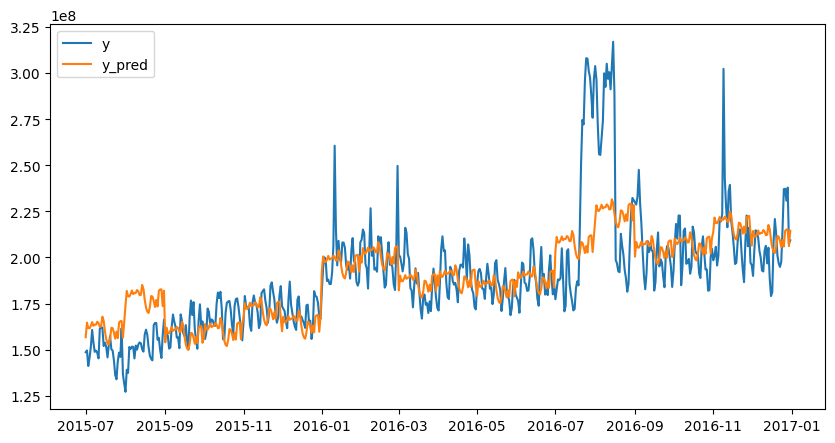

In [92]:
# Plot y and y_pred in the same plot
plt.figure(figsize=(10, 5))
plt.plot(y, label='y')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [91]:
calculate_smape(y["Visits"].to_numpy(), y_pred["Visits"].to_numpy())

7.36

In [96]:
future_1 = dp.out_of_sample(steps=60)

c:\Users\ivan.trujillo_blueta\proyectos\personal\web_traffic\venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [98]:
future_1.head()

,trend
551,551.0
552,552.0
553,553.0
554,554.0
555,555.0


In [104]:
future_1.shape

(60, 1)

In [106]:
future_2 = pd.date_range(start=y.index[-1], periods=61, freq='D')[1:]
future_2 = pd.DataFrame(future_2, columns=["date"])
future_2["dump"] = 1
future_2["day"] = future_2["date"].dt.day
future_2["month"] = future_2["date"].dt.month
future_2 = future_2.drop('dump', axis=1)
future_2 = future_2.set_index('date')
future_2.head()

,day,month
date,,
2017-01-01,1,1
2017-01-02,2,1
2017-01-03,3,1
2017-01-04,4,1
2017-01-05,5,1


In [107]:
future_2.shape

(60, 2)

In [111]:
y_pred_lin_fut = linear_regression.predict(future_1)
y_pred_xgb_fut = xgb_model.predict(future_2)

y_pred_fut = y_pred_lin_fut + y_pred_xgb_fut.reshape(-1, 1)

y_pred_fut = pd.DataFrame(
    y_pred_fut, index=future_2.index, columns=["Visits"],
)

In [112]:
y_pred_fut.head()

,Visits
date,
2017-01-01,2.391001e+08
2017-01-02,2.470256e+08
2017-01-03,2.441358e+08
2017-01-04,2.439627e+08
2017-01-05,2.453084e+08


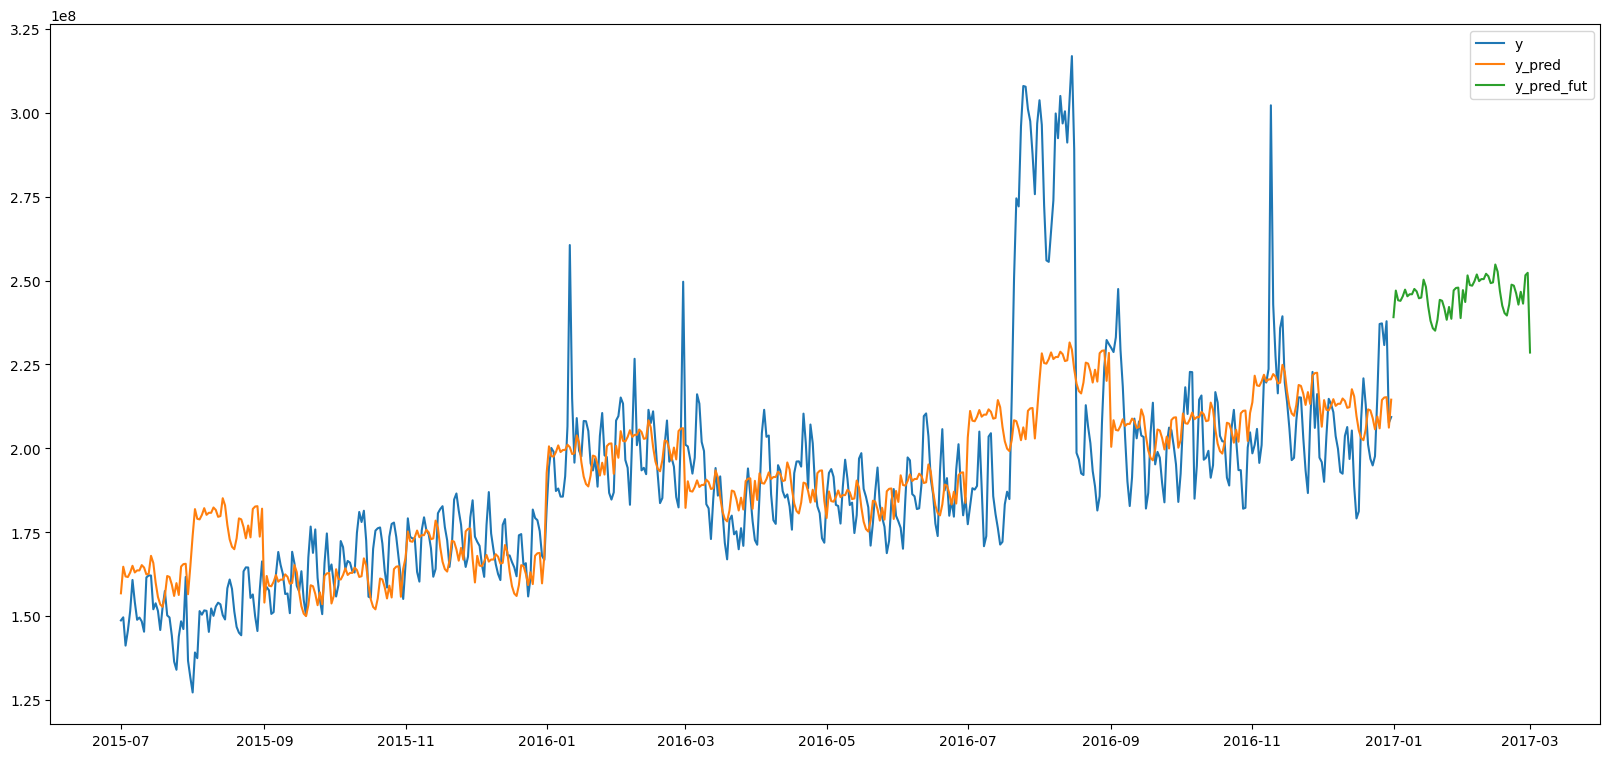

In [118]:
ax = plt.subplot(2, 1, 1)
ax.figure.set_size_inches(20, 20)
plt.plot(y, label='y')
plt.plot(y_pred, label='y_pred')
plt.plot(y_pred_fut, label='y_pred_fut')
plt.legend()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

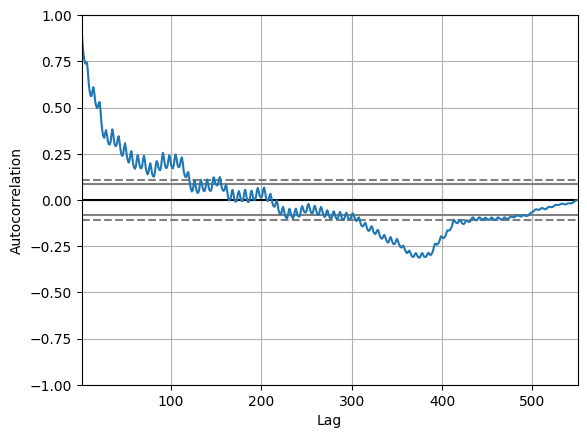

In [128]:
pd.plotting.autocorrelation_plot(y)

In [130]:
# ARIMA model
model = ARIMA(y, order=(14, 1, 0))
model_fit = model.fit()
model_fit.summary()

c:\Users\ivan.trujillo_blueta\proyectos\personal\web_traffic\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ivan.trujillo_blueta\proyectos\personal\web_traffic\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ivan.trujillo_blueta\proyectos\personal\web_traffic\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Visits   No. Observations:                  550
Model:                ARIMA(14, 1, 0)   Log Likelihood               -9678.152
Date:                Tue, 14 May 2024   AIC                          19386.303
Time:                        13:07:54   BIC                          19450.925
Sample:                    07-01-2015   HQIC                         19411.558
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0812      0.020     -3.969      0.000      -0.121      -0.041
ar.L2         -0.1436      0.034     -4.283      0.000      -0.209      -0.078
ar.L3         -0.0726      0.034     -2.108      0.035      -0.140      -0.005
ar.L4         -0.0463      0.033     -1.406      0.160      -0.111       0.018
ar.L5         -0.0738      0.028     -2.663      0.008      -0.128      -0.019
ar.L6         -0.0142      0.042     -0.342      0.733      -0.096       0.067
ar.L7          0.1137      0.023      4.931      0.000       0.069       0.159
ar.L8          0.0194      0.049      0.395      0.693      -0.077       0.116
ar.L9         -0.1109      0.032     -3.501      0.000      -0.173      -0.049
ar.L10        -0.0980      0.043     -2.299      0.022      -0.182      -0.014
ar.L11        -0.0918      0.026     -3.600      0.000      -0.142      -0.042
ar.L12        -0.1535      0.027     -5.699      0.000      -0.206      -0.101
ar.L13        -0.0088      0.039     -0.225      0.822      -0.085       0.068
ar.L14         0.0934      0.025      3.786      0.000       0.045       0.142
sigma2      1.124e+14   2.51e-16   4.49e+29      0.000    1.12e+14    1.12e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              4698.73
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.09e+43. Standard errors may be unstable.
"""

<Axes: xlabel='date'>

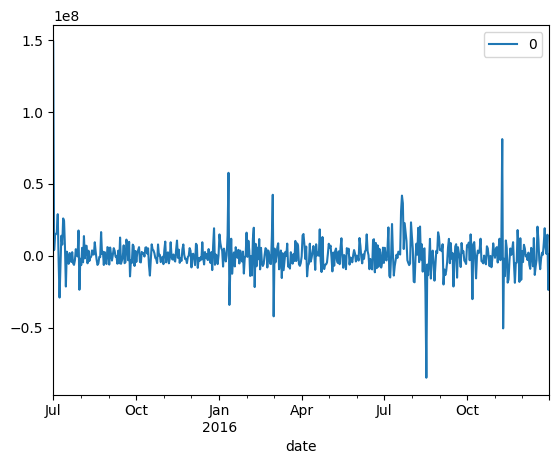

In [131]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<Axes: ylabel='Density'>

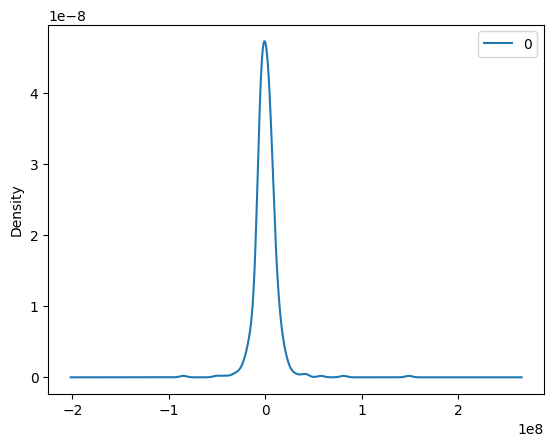

In [132]:
residuals.plot(kind='kde')

In [133]:
residuals.describe()

,0
count,5.500000e+02
mean,6.358701e+05
std,1.264815e+07
min,-8.483536e+07
25%,-5.008216e+06
50%,1.204337e+05
75%,5.340604e+06
max,1.486725e+08


In [137]:
model_fit.get_prediction(start=y.index[-60], end=y.index[-1]).

AttributeError: 'PredictionResults' object has no attribute 'plot_predict'

In [142]:
forecast = model_fit.forecast(steps=60)

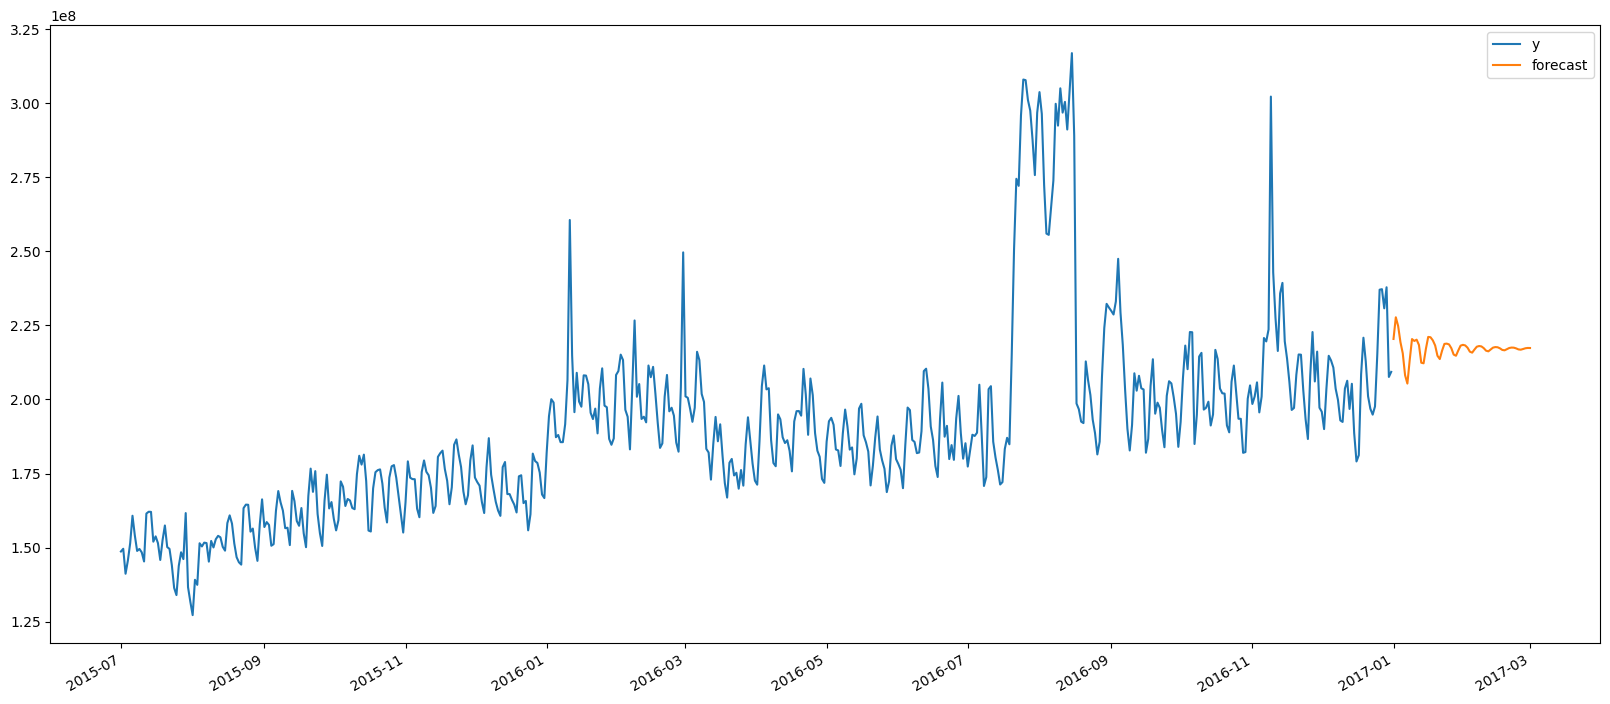

In [147]:
ax = plt.subplot(2, 1, 1)
ax.figure.set_size_inches(20, 20)
plt.plot(y, label='y')
forecast.plot(label='forecast')
plt.legend()
plt.show()

In [149]:
# RNN model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(y, window_size, batch_size, shuffle_buffer_size)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 191379936.0000 - mae: 191379936.0000 - learning_rate: 1.0000e-08
Epoch 2/100
 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 193590800.0000 - mae: 193590800.0000

C:\Users\ivan.trujillo_blueta\.conda\envs\python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 192086544.0000 - mae: 192086544.0000 - learning_rate: 1.1220e-08
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 190974720.0000 - mae: 190974720.0000 - learning_rate: 1.2589e-08
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 191372048.0000 - mae: 191372048.0000 - learning_rate: 1.4125e-08
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 191321568.0000 - mae: 191321568.0000 - learning_rate: 1.5849e-08
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 192922624.0000 - mae: 192922624.0000 - learning_rate: 1.7783e-08
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 190795696.0000 - mae: 190795712.0000 - learning_rate: 1.9953e-08
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 192427376.0000 - mae: 192427360.0000 - learning_rate: 2.2387e-08
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 191026080.0000 - mae: 191026080.0000 - learning_rate: 2.5119e-08
Epoch 10/100

KeyError: 'lr'

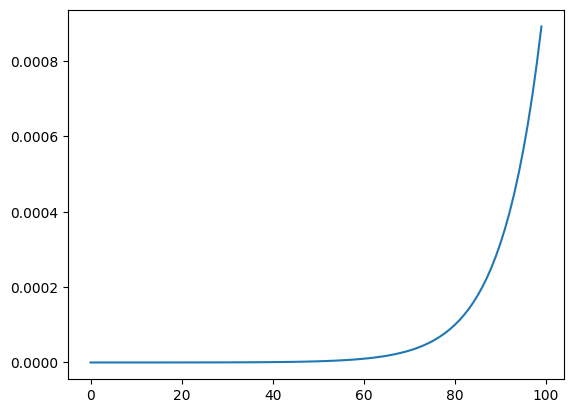

In [151]:
plt.plot(history.history["learning_rate"])

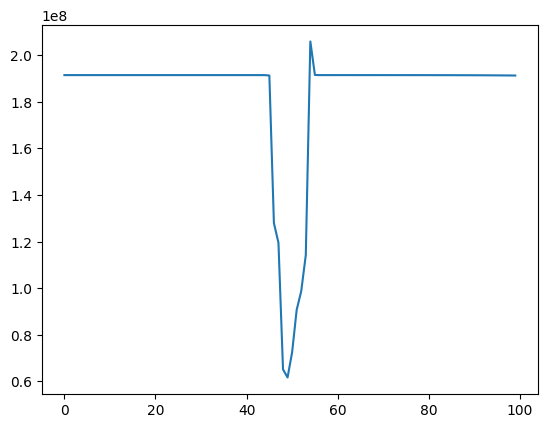

In [152]:
plt.plot(history.history["loss"])

In [158]:
y_pred_2 = model.predict(y.to_numpy().reshape(1, -1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


In [160]:
y_pred_2 = pd.DataFrame(
    y_pred_2.reshape(-1, 1), index=y.index, columns=["Visits"],
)

In [161]:
y_pred_2.head()

,Visits
date,
2015-07-01,196845.625
2015-07-02,196845.625
2015-07-03,196845.625
2015-07-04,196845.625
2015-07-05,196845.625


In [163]:
y_pred_rnn = model_forecast(model, y, window_size)
y_pred_rnn = y_pred_rnn[:, -1, 0]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\ivan.trujillo_blueta\.conda\envs\python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [164]:
y_pred_rnn.shape

(491,)

In [165]:
future_3 = pd.date_range(start=y.index[-1], periods=492, freq='D')[1:]
future_3 = pd.DataFrame(future_3, columns=["date"])
future_3["dump"] = 1
future_3 = future_3.set_index('date')
y_pred_rnn = pd.DataFrame(
    y_pred_rnn, index=future_3.index, columns=["Visits"],
)

In [166]:
y_pred_rnn.head()

,Visits
date,
2017-01-01,196845.625
2017-01-02,196845.625
2017-01-03,196845.625
2017-01-04,196845.625
2017-01-05,196845.625


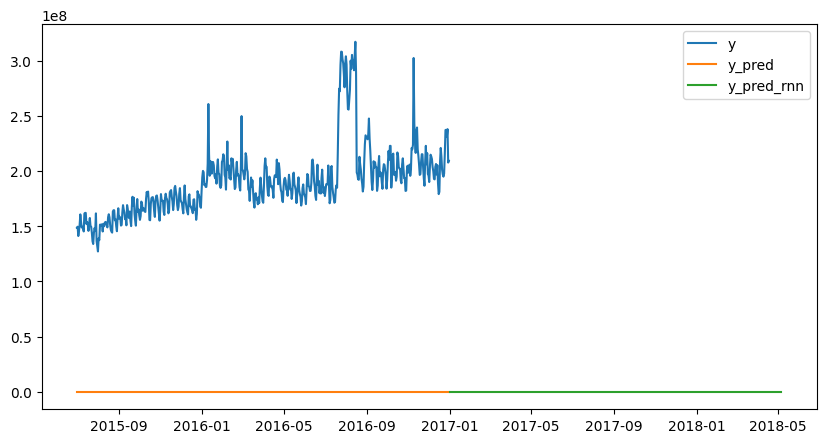

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(y, label='y')
plt.plot(y_pred_2, label='y_pred')
plt.plot(y_pred_rnn, label='y_pred_rnn')
plt.legend()
plt.show()

In [169]:
calculate_smape(y["Visits"].to_numpy(), y_pred_2["Visits"].to_numpy())

199.58